In [48]:
import math
import pandas as pd
import numpy as np
import requests
# import tensorflow as tf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf

# Analisis de sentimientos
import requests
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Ejecucion con grafica
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Normalizar datos
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
#from keras.models import Sequential
#from keras.layers import Dense, LSTM, Dropout, GRU
#from keras import Input

#get_ipython().run_line_magic('matplotlib', 'inline')

#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.callbacks import EarlyStopping

#### Probar con la grafica RTX 5090

In [4]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Device: cuda
GPU: NVIDIA GeForce RTX 5090


## Declarar variables

In [5]:
# News API
url = "https://newsapi.org/v2/everything?" 
API_KEY = "88282befa9004fc388fb57f794bdaefb"
today = datetime.now()
start_date = (today - timedelta(days=31)).strftime("%Y-%m-%d")
end_date = today.strftime("%Y-%m-%d")
# Yfinance
df_netflix_yfinance = yf.download(tickers="NFLX", start=today - timedelta(days=365*3), end=end_date, auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [6]:
df_netflix_yfinance.columns = [col[0] for col in df_netflix_yfinance.columns]
df_netflix_yfinance.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [7]:
# Configurar modelo FinBERT
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
finbert = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone", torch_dtype="auto").to(device)
finbert.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [8]:
def get_news():
    params = {
        "q": "(Netflix OR NFLX) AND financial",
        "apiKey": API_KEY,
        "language": "en",
        "from": start_date,
        "to": end_date,
        "sortBy": "popularity"
    }
    
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        articles = data.get("articles", [])
        df_news = pd.DataFrame(articles)
        return df_news
    else:
        raise Exception(f"Error al obtener datos de NewsAPI: {response.status_code} - {response.text}")

In [9]:
df_news = get_news()

In [11]:
def create_combined_text(row):
    title = row.get('title') or ""
    description = row.get('description') or ""
    content = row.get('content') or ""
    return f"{title} {description} {content}".strip()
'''
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True, max_length=512)
    outputs = model(inputs)
    predictions = tf.nn.softmax(outputs.logits, axis=-1).numpy()[0]
    sentiment = ['positive', 'negative', 'neutral'][predictions.argmax()]
    return sentiment'''

'\ndef predict_sentiment(text):\n    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True, max_length=512)\n    outputs = model(inputs)\n    predictions = tf.nn.softmax(outputs.logits, axis=-1).numpy()[0]\n    sentiment = [\'positive\', \'negative\', \'neutral\'][predictions.argmax()]\n    return sentiment'

In [12]:
df_news['combined_text'] = df_news.apply(create_combined_text, axis=1)
df_news

,source,author,title,description,url,urlToImage,publishedAt,content,combined_text
0,"{'id': 'the-verge', 'name': 'The Verge'}",Dominic Preston,Disney will stop reporting its streaming subsc...,Disney announced that it will no longer report...,https://www.theverge.com/news/719730/disney-pl...,https://platform.theverge.com/wp-content/uploa...,2025-08-06T12:25:09Z,<ul><li></li><li></li><li></li></ul>\r\nFinanc...,Disney will stop reporting its streaming subsc...
1,"{'id': None, 'name': 'NPR'}",Rafael Nam,Here's a puzzling question: Why are stocks at ...,President Trump's tariffs could hit the econom...,https://www.npr.org/2025/07/27/nx-s1-5476238/t...,https://npr.brightspotcdn.com/dims3/default/st...,2025-07-27T09:00:00Z,From businesses to Americans across the countr...,Here's a puzzling question: Why are stocks at ...
2,"{'id': 'business-insider', 'name': 'Business I...",Lara O'Reilly,"2 become 1: Starting next year, you'll be stre...",Speculation has been mounting inside the media...,https://www.businessinsider.com/disney-hulu-fu...,https://i.insider.com/68933ef93d5881a51c1eaf7b...,2025-08-06T12:20:11Z,Disney Plus ranks among the best streaming ser...,"2 become 1: Starting next year, you'll be stre..."
3,"{'id': 'business-insider', 'name': 'Business I...",Peter Kafka,Is this TV's endgame? A discussion with analys...,"The TV business has been shrinking for years, ...",https://www.businessinsider.com/tv-cable-dying...,https://i.insider.com/688932ce85e81483682ee4a1...,2025-07-30T10:01:01Z,UFC fighters Robert Whittaker and Reinier de R...,Is this TV's endgame? A discussion with analys...
4,"{'id': 'business-insider', 'name': 'Business I...",Lucia Moses,Paramount's deal with Skydance is finally clos...,David Ellison has finally closed the Paramount...,https://www.businessinsider.com/paramount-skyd...,https://i.insider.com/6893c68b194a2d49b8ae205f...,2025-08-06T22:16:28Z,David Ellison is taking over Paramount Skydanc...,Paramount's deal with Skydance is finally clos...
...,...,...,...,...,...,...,...,...,...
94,"{'id': None, 'name': 'Cartoon Brew'}",Jamie Lang,Crunchyroll Announces Layoffs Amid Global Reor...,Crunchyroll will undergo another round of layo...,https://www.cartoonbrew.com/anime/crunchyroll-...,https://www.cartoonbrew.com/wp-content/uploads...,2025-08-12T15:11:10Z,A day after unveiling a major deal with Delta ...,Crunchyroll Announces Layoffs Amid Global Reor...
95,"{'id': None, 'name': 'TVLine'}",Dave Nemetz,Love Con Revenge Trailer: Romance Scam Victims...,Have you been the victim of a romance scam? He...,https://tvline.com/trailers/love-con-revenge-n...,https://tvline.com/wp-content/uploads/2025/08/...,2025-08-08T23:45:48Z,Have you been the victim of a romance scam? He...,Love Con Revenge Trailer: Romance Scam Victims...
96,"{'id': None, 'name': 'Reason'}",Elizabeth Nolan Brown,Is Conscientiousness Cratering? It Depends on ...,"Despite those viral charts you may have seen, ...",https://reason.com/2025/08/18/is-conscientious...,https://d2eehagpk5cl65.cloudfront.net/img/q60/...,2025-08-18T15:43:48Z,"The world needs conscientious people, and cons...",Is Conscientiousness Cratering? It Depends on ...
97,"{'id': None, 'name': 'Thoughtbot.com'}",Ran Craycraft,70 Companies You Didn't Know Were Using Rails ...,,https://thoughtbot.com/blog/70-companies-you-d...,https://images.prismic.io/thoughtbot-website/a...,2025-08-05T00:00:00Z,"For twenty-two years, thoughtbot has helped co...",70 Companies You Didn't Know Were Using Rails ...


## NOTA: El metodo FinBERT devuelve labels en formato: 'positive', 'negative', 'neutral'; sin embargo en el repo de
## 'yiyanghkust/finbert-tone' devuelve '#LABEL_0: neutral; LABEL_1: positive; LABEL_2: negative'

In [9]:
'''
#Predecir las noticias por bloques
def predict_sentiment_batch(texts, batch_size=16):
    sentiments = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        
        # Tokenizar lote
        encoded_inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="tf"
        )
        
        # Predicción
        outputs = model(encoded_inputs)
        probs = tf.nn.softmax(outputs.logits, axis=-1).numpy()

        label_list = ['positive', 'negative', 'neutral']
        batch_sentiments = [ label_list[p.argmax()] for p in probs ]
        sentiments.extend(batch_sentiments)
    
    return sentiments

def predict_sentiment_from_news(df_news, batch_size=16):
    # Preparar texto combinado
    df_news['combined_text'] = df_news.apply(create_combined_text, axis=1)
    df_news['publishedAt'] = pd.to_datetime(df_news['publishedAt']).dt.date

    # Predecir sentimientos en lotes (batches)
    texts = df_news['combined_text'].tolist()
    sentiments = predict_sentiment_batch(texts, batch_size=batch_size)
    df_news['sentiment'] = sentiments
    #df_news['sentiment'] = df_news['combined_text'].apply(predict_sentiment)

    # Agrupar y contar por fecha
    sentiment_counts = df_news.groupby('publishedAt')['sentiment'].value_counts().unstack().fillna(0)
    sentiment_counts.index = pd.to_datetime(sentiment_counts.index)

    # Convertir a lista de diccionarios para cada día
    sentiment_data = []
    for date, row in sentiment_counts.iterrows():
        sentiment_data.append({
            'Date': date,
            'Positive': row.get('positive', 0),
            'Negative': row.get('negative', 0),
            'Neutral': row.get('neutral', 0)
        })

    # Devolver DataFrame con sentimientos diarios
    return pd.DataFrame(sentiment_data).set_index('Date').sort_index()
'''

In [13]:
# Usar el mapeo nativo del modelo (evita suposiciones)
id2label = finbert.config.id2label  # e.g. {0:'neutral', 1:'positive', 2:'negative'}

@torch.no_grad()
def predict_sentiment_batch(texts, batch_size=16, max_length=512):
    all_probs = []
    all_labels = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        encoded_inputs = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        encoded_inputs = {k: v.to(device) for k, v in encoded_inputs.items()}
        outputs = finbert(**encoded_inputs)
        #axis - tensorflow -- dim - torch
        #probs = torch.softmax(outputs.logits, axis=-1).numpy()  # (B, num_labels)
        probs = torch.softmax(outputs.logits, dim=-1)
        all_probs.append(probs.detach().cpu().numpy())
        
        argmax = probs.argmax(dim=-1).detach().cpu().numpy()
        #all_labels.extend([id2label[int(p.argmax())] for p in probs])
        all_labels.extend([id2label[int(x)] for x in argmax])
    return np.vstack(all_probs), all_labels

def predict_sentiment_from_news(df_news):
    if df_news.empty:
        idx = pd.date_range(start=pd.to_datetime(start_date), end=pd.to_datetime(end_date), freq="D")
        return pd.DataFrame(0.0, index=idx, columns=["Neutral","Positive","Negative"])

    df_news['combined_text'] = df_news.apply(create_combined_text, axis=1)
    df_news['publishedAt'] = pd.to_datetime(df_news['publishedAt'], utc=True, errors='coerce').dt.tz_convert('America/New_York').dt.date
    probs, labels = predict_sentiment_batch(df_news['combined_text'].tolist(), batch_size=16)
    cols = [id2label[i] for i in range(probs.shape[1])]
    dfp = pd.DataFrame(probs, columns=cols)
    dfp['Date'] = pd.to_datetime(df_news['publishedAt'])
    # promedio diario de probabilidades
    daily = dfp.groupby('Date')[cols].mean().sort_index()
    # renombrar a mayúsculas inicial si quieres
    daily = daily.rename(columns=str.capitalize)
    return daily

In [14]:
sentiment_counts = predict_sentiment_from_news(df_news)
print(sentiment_counts)


             Neutral  Positive  Negative
Date                                    
2025-07-24  0.126272  0.000232  0.873497
2025-07-26  0.999783  0.000082  0.000135
2025-07-27  0.000004  0.000001  0.999995
2025-07-28  0.634336  0.002924  0.362740
2025-07-29  0.959012  0.040772  0.000215
2025-07-30  0.793324  0.159359  0.047317
2025-07-31  0.565043  0.149009  0.285948
2025-08-01  0.744102  0.254950  0.000948
2025-08-02  0.790033  0.189773  0.020194
2025-08-04  0.599445  0.400113  0.000442
2025-08-06  0.734372  0.210161  0.055467
2025-08-07  0.347881  0.368772  0.283347
2025-08-08  0.408500  0.590973  0.000527
2025-08-09  0.994649  0.005304  0.000047
2025-08-11  0.751593  0.248364  0.000043
2025-08-12  0.328580  0.668237  0.003182
2025-08-13  0.999398  0.000152  0.000450
2025-08-14  0.999432  0.000527  0.000041
2025-08-15  0.749969  0.250023  0.000008
2025-08-16  0.999995  0.000002  0.000003
2025-08-17  0.609057  0.111305  0.279638
2025-08-18  0.438406  0.008904  0.552690
2025-08-19  0.64

In [18]:
def calculate_technical_indicators(data):
    df = df_netflix_yfinance.copy()
    df['MA5'] = df['Close'].rolling(window=5).mean() # Se queda, funciona para mercados volatiles y no volatiles
    df['MA20'] = df['Close'].rolling(window=20).mean() # Se queda, funciona para mercados volatiles y no volatiles
    df['MA50'] = df['Close'].rolling(window=50).mean() # Se queda, funciona para mercados volatiles y no volatiles
    
    # MACD y Signal_Line -- Se queda, funciona para mercados volatiles y no volatiles
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # RSI - Se queda, funciona para mercados volatiles y no volatiles
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    rs = gain / (loss + 1e-10)
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Otros indicadores
    df['Returns'] = df['Close'].pct_change()
    df['Volatility'] = df['Returns'].rolling(window=20).std()
    df['Volume_MA'] = df['Volume'].rolling(window=5).mean()
    
    # Rellenar valores faltantes
    #df = df.fillna(method='bfill').fillna(method='ffill')
    df = df.bfill().ffill()
    return df

In [19]:
df_final = calculate_technical_indicators(df_netflix_yfinance)
df_final

,Close,High,Low,Open,Volume,MA5,MA20,MA50,MACD,Signal_Line,RSI,Returns,Volatility,Volume_MA
Date,,,,,,,,,,,,,,
2022-08-26,223.279999,236.949997,223.149994,233.630005,5349800,224.419998,229.883501,244.753601,0.000000,0.000000,57.282140,0.005778,0.031425,6821680.0
2022-08-29,224.570007,229.869995,221.520004,221.929993,7109400,224.419998,229.883501,244.753601,0.102907,0.020581,57.282140,0.005778,0.031425,6821680.0
2022-08-30,220.649994,229.789993,218.740005,226.660004,5740400,224.419998,229.883501,244.753601,-0.130349,-0.009605,57.282140,-0.017456,0.031425,6821680.0
2022-08-31,223.559998,233.880005,223.429993,227.000000,8615900,224.419998,229.883501,244.753601,-0.079476,-0.023579,57.282140,0.013188,0.031425,6821680.0
2022-09-01,230.039993,230.369995,219.470001,220.720001,7292900,224.419998,229.883501,244.753601,0.478209,0.076779,57.282140,0.028985,0.031425,6821680.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-18,1245.089966,1251.160034,1235.449951,1235.630005,2111100,1228.863989,1191.281494,1230.650803,2.006240,-7.333411,67.717070,0.004956,0.015949,2764960.0
2025-08-19,1214.150024,1241.000000,1192.790039,1240.199951,3707700,1226.637988,1192.484998,1230.104404,1.899373,-5.486854,56.484101,-0.024850,0.014879,3050740.0
2025-08-20,1213.859985,1223.000000,1193.310059,1218.000000,2434400,1228.521997,1194.338995,1229.892405,1.770863,-4.035311,63.190252,-0.000239,0.014603,2985140.0


In [20]:
# Paso 3: Fusionar con sentimiento
sentiment_counts = sentiment_counts.reindex(df_final.index, method='ffill').fillna(0)
df_final_bigdata = pd.concat([df_final, sentiment_counts], axis=1).fillna(0)
df_final_bigdata

,Close,High,Low,Open,Volume,MA5,MA20,MA50,MACD,Signal_Line,RSI,Returns,Volatility,Volume_MA,Neutral,Positive,Negative
Date,,,,,,,,,,,,,,,,,
2022-08-26,223.279999,236.949997,223.149994,233.630005,5349800,224.419998,229.883501,244.753601,0.000000,0.000000,57.282140,0.005778,0.031425,6821680.0,0.000000,0.000000,0.000000
2022-08-29,224.570007,229.869995,221.520004,221.929993,7109400,224.419998,229.883501,244.753601,0.102907,0.020581,57.282140,0.005778,0.031425,6821680.0,0.000000,0.000000,0.000000
2022-08-30,220.649994,229.789993,218.740005,226.660004,5740400,224.419998,229.883501,244.753601,-0.130349,-0.009605,57.282140,-0.017456,0.031425,6821680.0,0.000000,0.000000,0.000000
2022-08-31,223.559998,233.880005,223.429993,227.000000,8615900,224.419998,229.883501,244.753601,-0.079476,-0.023579,57.282140,0.013188,0.031425,6821680.0,0.000000,0.000000,0.000000
2022-09-01,230.039993,230.369995,219.470001,220.720001,7292900,224.419998,229.883501,244.753601,0.478209,0.076779,57.282140,0.028985,0.031425,6821680.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-18,1245.089966,1251.160034,1235.449951,1235.630005,2111100,1228.863989,1191.281494,1230.650803,2.006240,-7.333411,67.717070,0.004956,0.015949,2764960.0,0.438406,0.008904,0.552690
2025-08-19,1214.150024,1241.000000,1192.790039,1240.199951,3707700,1226.637988,1192.484998,1230.104404,1.899373,-5.486854,56.484101,-0.024850,0.014879,3050740.0,0.644895,0.253701,0.101405
2025-08-20,1213.859985,1223.000000,1193.310059,1218.000000,2434400,1228.521997,1194.338995,1229.892405,1.770863,-4.035311,63.190252,-0.000239,0.014603,2985140.0,0.207501,0.598980,0.193519


In [21]:
features = ['Close', 'Volume', 'MA5', 'RSI', 'MACD', 'Signal_Line', 'Returns', 'Volatility', 'Volume_MA', 'Neutral','Positive','Negative']
#features = ['Close', 'Volume', 'MA5', 'RSI', 'MACD', 'Signal_Line', 'Returns', 'Volatility', 'Volume_MA']
#features = ['Close', 'Volume', 'High', 'Low', 'Open']

In [ ]:
feature_scaler = RobustScaler()
target_scaler = RobustScaler()

In [23]:
# Asegurar tipo float y rellenar faltantes
data = df_final_bigdata[features].astype(float).ffill().bfill()

In [24]:
# Dividir en train/test 70/30
split = int(len(data) * 0.8)
train_data = data.iloc[:split]
test_data = data.iloc[split:]

In [25]:
# Aca estaba tu error, en un modelo nunca se debe entrenar los datos de testeo, solo transformarlos ya que hay data-leak
X_train_scaled = feature_scaler.fit_transform(train_data)
y_train_scaled = target_scaler.fit_transform(train_data[['Close']])

X_test_scaled = feature_scaler.transform(test_data)
y_test_scaled = target_scaler.transform(test_data[['Close']])

In [26]:
# Crear secuencias de entrada -- Modificacion ahora hacer la secuencia en base a los datos de entrenamiento y testing
lookback = 60
X_train, y_train = [], []
for i in range(lookback, len(X_train_scaled)):
    X_train.append(X_train_scaled[i - lookback:i])
    y_train.append(y_train_scaled[i, 0])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Test
X_test, y_test = [], []
for i in range(lookback, len(X_test_scaled)):
    X_test.append(X_test_scaled[i - lookback:i])
    y_test.append(y_test_scaled[i, 0])

X_test = np.array(X_test)
y_test = np.array(y_test)

### Aqui acaba la prueba

### Modelo Complejo PyTorch

Como en este apartado usaremos PyTorch y no TensorFlow y la logica cambie, asi que para esta parte pase mi codigo en chatgpt para que lo transforme a PyTorch

In [36]:
class SeqDataset(Dataset):
    def __init__(self, X, y):
        X = X.astype(np.float32)
        y = y.astype(np.float32)
        self.X = torch.from_numpy(X)  # (N, T, F)
        self.y = torch.from_numpy(y).unsqueeze(-1)  # (N, 1)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 64

train_ds = SeqDataset(X_train, y_train)
test_ds  = SeqDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [37]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden=64, dense=32):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden, dense)
        self.act = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.out = nn.Linear(dense, 1)
    def forward(self, x):
        # x: (B, T, F)
        out, _ = self.lstm(x)
        out = out[:, -1, :]            # última salida temporal
        out = self.dropout1(out)
        out = self.fc1(out)
        out = self.act(out)
        out = self.dropout2(out)
        return self.out(out)

class GRURegressor(nn.Module):
    def __init__(self, input_dim, hidden=64, dense=32):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden, dense)
        self.act = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.out = nn.Linear(dense, 1)
    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.dropout1(out)
        out = self.fc1(out)
        out = self.act(out)
        out = self.dropout2(out)
        return self.out(out)

In [38]:
INPUT_DIM = X_train.shape[2]
lr = 1e-3

In [52]:
del model

In [53]:
#model = LSTMRegressor(INPUT_DIM).to(device)
model = GRURegressor(INPUT_DIM).to(device)
#del model_LSTM

In [54]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [55]:
EPOCHS = 100
PATIENCE = 20
best_val = float("inf")
pat = 0
history = {"train": [], "val": []}

for epoch in range(1, EPOCHS+1):
    # train
    model.train()
    train_losses = []
    for Xb, yb in train_loader:
        Xb = Xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = float(np.mean(train_losses))

    # val
    model.eval()
    val_losses = []
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb = Xb.to(device)
            yb = yb.to(device)
            preds = model(Xb)
            loss = criterion(preds, yb)
            val_losses.append(loss.item())
    val_loss = float(np.mean(val_losses))

    history["train"].append(train_loss)
    history["val"].append(val_loss)

    print(f"Epoch {epoch:03d} | train {train_loss:.6f} | val {val_loss:.6f}")

    if val_loss < best_val - 1e-8:
        best_val = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        pat = 0
    else:
        pat += 1
        if pat >= PATIENCE:
            print("Early stopping!")
            break

Epoch 001 | train 0.249669 | val 3.703184
Epoch 002 | train 0.113484 | val 1.969238
Epoch 003 | train 0.067833 | val 1.290157
Epoch 004 | train 0.042431 | val 0.976619
Epoch 005 | train 0.022515 | val 0.454370
Epoch 006 | train 0.016046 | val 0.435671
Epoch 007 | train 0.012078 | val 0.310482
Epoch 008 | train 0.009410 | val 0.361830
Epoch 009 | train 0.009640 | val 0.404061
Epoch 010 | train 0.009512 | val 0.410991
Epoch 011 | train 0.009583 | val 0.364413
Epoch 012 | train 0.008382 | val 0.358305
Epoch 013 | train 0.008272 | val 0.280457
Epoch 014 | train 0.007783 | val 0.348563
Epoch 015 | train 0.009360 | val 0.289519
Epoch 016 | train 0.007878 | val 0.303472
Epoch 017 | train 0.007818 | val 0.361681
Epoch 018 | train 0.008756 | val 0.244011
Epoch 019 | train 0.008594 | val 0.263791
Epoch 020 | train 0.008312 | val 0.299618
Epoch 021 | train 0.008385 | val 0.259905
Epoch 022 | train 0.008137 | val 0.320343
Epoch 023 | train 0.006797 | val 0.277603
Epoch 024 | train 0.007269 | val 0

In [56]:
# Restaurar mejor estado
model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

<All keys matched successfully>

In [58]:
model.eval()
with torch.no_grad():
    preds_scaled = []
    for Xb, _ in val_loader:
        Xb = Xb.to(device)
        out = model(Xb).detach().cpu().numpy()
        preds_scaled.append(out)
preds_scaled = np.vstack(preds_scaled)

In [59]:
# Invertir escala
preds_actual = target_scaler.inverse_transform(preds_scaled)
y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_actual, preds_actual)
mae = mean_absolute_error(y_test_actual, preds_actual)
rmse = math.sqrt(mse)
mape = np.mean(np.abs((y_test_actual - preds_actual) / (y_test_actual + 1e-12))) * 100

print("\nModel Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")


Model Performance:
Mean Squared Error: 13215.43
Root Mean Squared Error: 114.96
Mean Absolute Error: 108.03
Mean Absolute Percentage Error: 8.96%


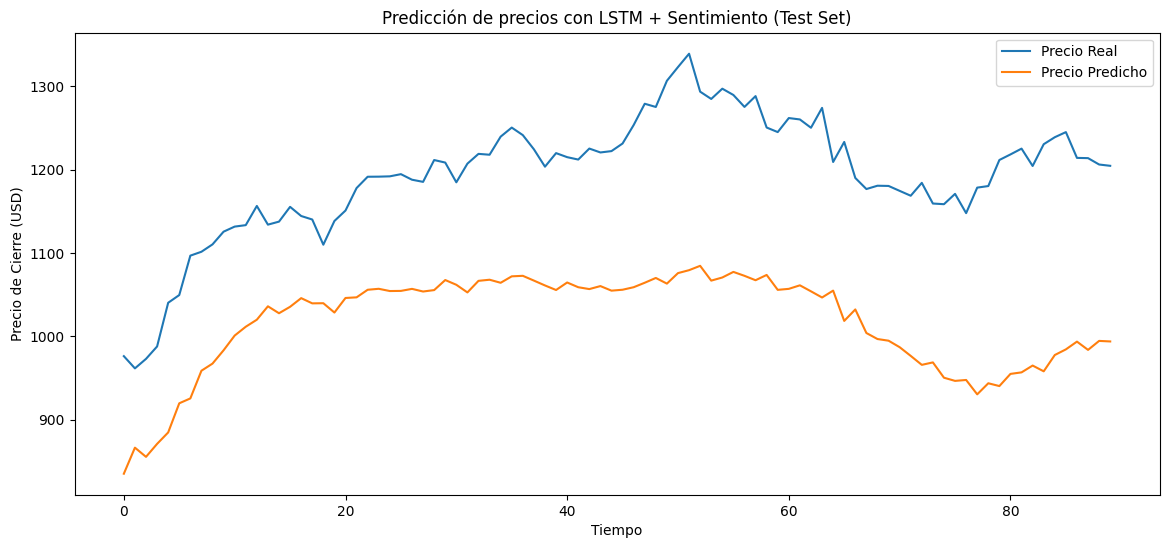

In [51]:
# Crear un DataFrame para facilitar el gráfico
valid = pd.DataFrame()
valid['Real'] = y_test_actual.ravel()
valid['Predicción'] = preds_actual.ravel()

# Graficar
plt.figure(figsize=(14, 6))
plt.plot(valid['Real'].values, label='Precio Real')
plt.plot(valid['Predicción'].values, label='Precio Predicho')
plt.title('Predicción de precios con LSTM + Sentimiento (Test Set)')
plt.xlabel('Tiempo')
plt.ylabel('Precio de Cierre (USD)')
plt.legend()
plt.show()

#### Podemos concluir segun internet:
    - MAPE < 10% = esta en un rango aceptable
    - MAPE < 9% = esta en un rango aceptable
    - RMSE 64 = Si es se predice si sube o baja la accion maximo habra una diferencia de 64$ aunque en algunos casos puede variar

## Vamos a probar con un modelo GRU

In [41]:
#features = ['Close', 'Volume', 'High', 'Low', 'Open']
features = ['Close', 'Volume', 'MA5', 'RSI', 'MACD', 'Signal_Line', 'Returns', 'Volatility', 'Volume_MA', 'Negative','Neutral','Positive']
#features = ['Close', 'Volume', 'MA5', 'RSI', 'MACD', 'Signal_Line', 'Returns', 'Volatility', 'Volume_MA']

In [42]:
data = df_final_bigdata[features].astype(float).ffill().bfill()

In [43]:
# Escalado
split = int(len(data) * 0.8)
train = data.iloc[:split]
test  = data.iloc[split:]

# 2) scalers entrenados SOLO con train
feature_scaler = RobustScaler()
target_scaler  = RobustScaler()

X_train_scaled = feature_scaler.fit_transform(train)
X_test_scaled  = feature_scaler.transform(test)

y_train_scaled = target_scaler.fit_transform(train[['Close']])
y_test_scaled  = target_scaler.transform(test[['Close']])

In [44]:
# Secuencias con lookback
lookback = 60

def create_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y[i, 0])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, lookback)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, lookback)

In [61]:
#del model_GRU

In [45]:
# Modelo GRU
model_GRU = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(units=64, return_sequences=False),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dropout(0.1),
    Dense(units=1)
])

optimizer = Adam(learning_rate=0.001)
model_GRU.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

In [46]:
hist = model_GRU.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/100
31/31 - 2s - 55ms/step - loss: 0.1425 - mae: 0.2742 - mse: 0.1425 - val_loss: 0.0764 - val_mae: 0.2646 - val_mse: 0.0764
Epoch 2/100
31/31 - 0s - 10ms/step - loss: 0.0407 - mae: 0.1544 - mse: 0.0407 - val_loss: 0.2591 - val_mae: 0.4846 - val_mse: 0.2591
Epoch 3/100
31/31 - 0s - 9ms/step - loss: 0.0220 - mae: 0.1092 - mse: 0.0220 - val_loss: 0.1233 - val_mae: 0.3363 - val_mse: 0.1233
Epoch 4/100
31/31 - 0s - 9ms/step - loss: 0.0162 - mae: 0.0996 - mse: 0.0162 - val_loss: 0.0574 - val_mae: 0.2278 - val_mse: 0.0574
Epoch 5/100
31/31 - 0s - 11ms/step - loss: 0.0166 - mae: 0.0967 - mse: 0.0166 - val_loss: 0.0486 - val_mae: 0.2093 - val_mse: 0.0486
Epoch 6/100
31/31 - 0s - 10ms/step - loss: 0.0141 - mae: 0.0890 - mse: 0.0141 - val_loss: 0.0496 - val_mae: 0.2127 - val_mse: 0.0496
Epoch 7/100
31/31 - 0s - 9ms/step - loss: 0.0131 - mae: 0.0855 - mse: 0.0131 - val_loss: 0.0135 - val_mae: 0.1010 - val_mse: 0.0135
Epoch 8/100
31/31 - 0s - 10ms/step - loss: 0.0124 - mae: 0.0857 - mse: 0

In [47]:
predicted_price = model_GRU.predict(X_test)
predictions_actual = target_scaler.inverse_transform(predicted_price)
y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


In [48]:
# Métricas
mse = np.mean((predictions_actual - y_test_actual) ** 2)
mae = np.mean(np.abs(predictions_actual - y_test_actual))
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_actual - predictions_actual) / y_test_actual)) * 100
print(f"\nModel Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")


Model Performance:
Mean Squared Error: 17192.13
Root Mean Squared Error: 131.12
Mean Absolute Error: 126.65
Mean Absolute Percentage Error: 10.56%


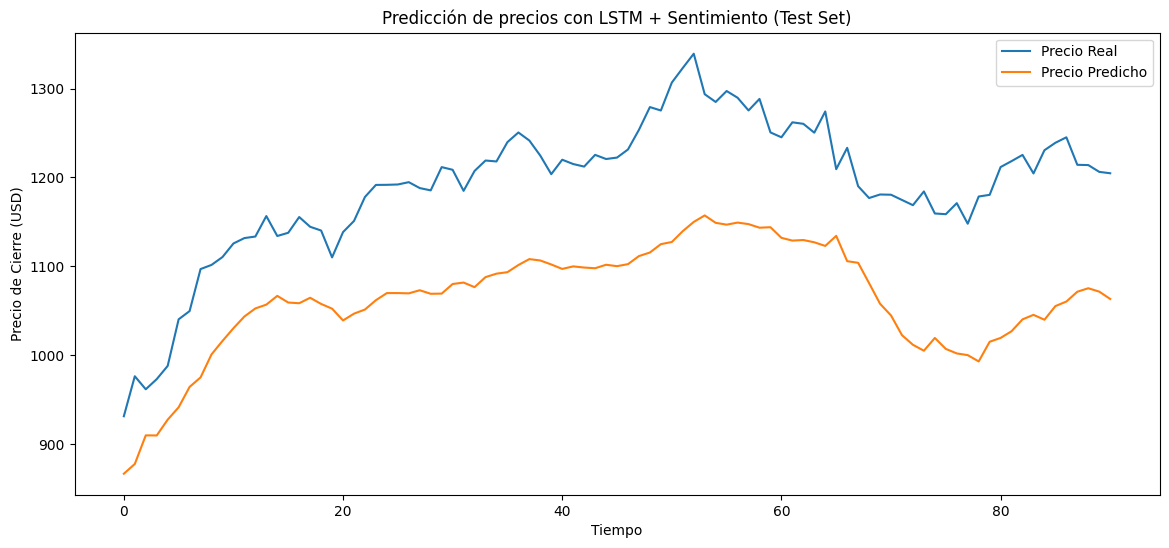

In [49]:
# Crear un DataFrame para facilitar el gráfico
valid = pd.DataFrame()
valid['Real'] = y_test_actual.ravel()
valid['Predicción'] = predictions_actual.ravel()

# Graficar
plt.figure(figsize=(14, 6))
plt.plot(valid['Real'].values, label='Precio Real')
plt.plot(valid['Predicción'].values, label='Precio Predicho')
plt.title('Predicción de precios con LSTM + Sentimiento (Test Set)')
plt.xlabel('Tiempo')
plt.ylabel('Precio de Cierre (USD)')
plt.legend()
plt.show()